# Projeto 3 - Rating de filmes (IMDB)

#### Por: Marcelo Lisboa de Castro Reis, Tiago Niemeyer Bergamo  e Bruno Kaczelnik- 2C Engenharia Insper

A partir do elenco, diretores, gênero do filme, ratings de filmes da mesma “linha”, bilheteria, pretendemos avaliar qual será a nota que um filme receberá. 

**O nosso projeto pode ser encontrado no seguinte GitHub:** https://github.com/Marcelolcr/Projeto-1---Ciencia-de-Dados.git

**Referências (Link do dataset):** 
- https://www.kaggle.com/carolzhangdc/imdb-5000-movie-dataset
- https://datasets.imdbws.com/


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import math as math
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from random import shuffle

Criando nosso dataframe e limpando-o, descartamos indicadores que não tem relação ou relevância alguma para a avaliação do filme:

In [2]:
#Criando o dataframe Treinamento
imdb = pd.read_csv('movie_metadata.csv')
imdb["movie_title"] = [k.replace("\xa0","") for k in imdb["movie_title"]]
imdb = imdb.dropna(0)
imdb = imdb.set_index('movie_title')
imdb = imdb.drop(['aspect_ratio','movie_imdb_link','facenumber_in_poster','plot_keywords'], axis=1)
imdb.head(3)#sort_values(by='gross', ascending=False).head(10)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,actor_3_name,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
movie_title,,,,,,,,,,,,,,,,,,,,,
Avatar,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,Wes Studi,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,33000
Pirates of the Caribbean: At World's End,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,Jack Davenport,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,0
Spectre,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,Stephanie Sigman,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,85000


## Análise Exploratória: ##

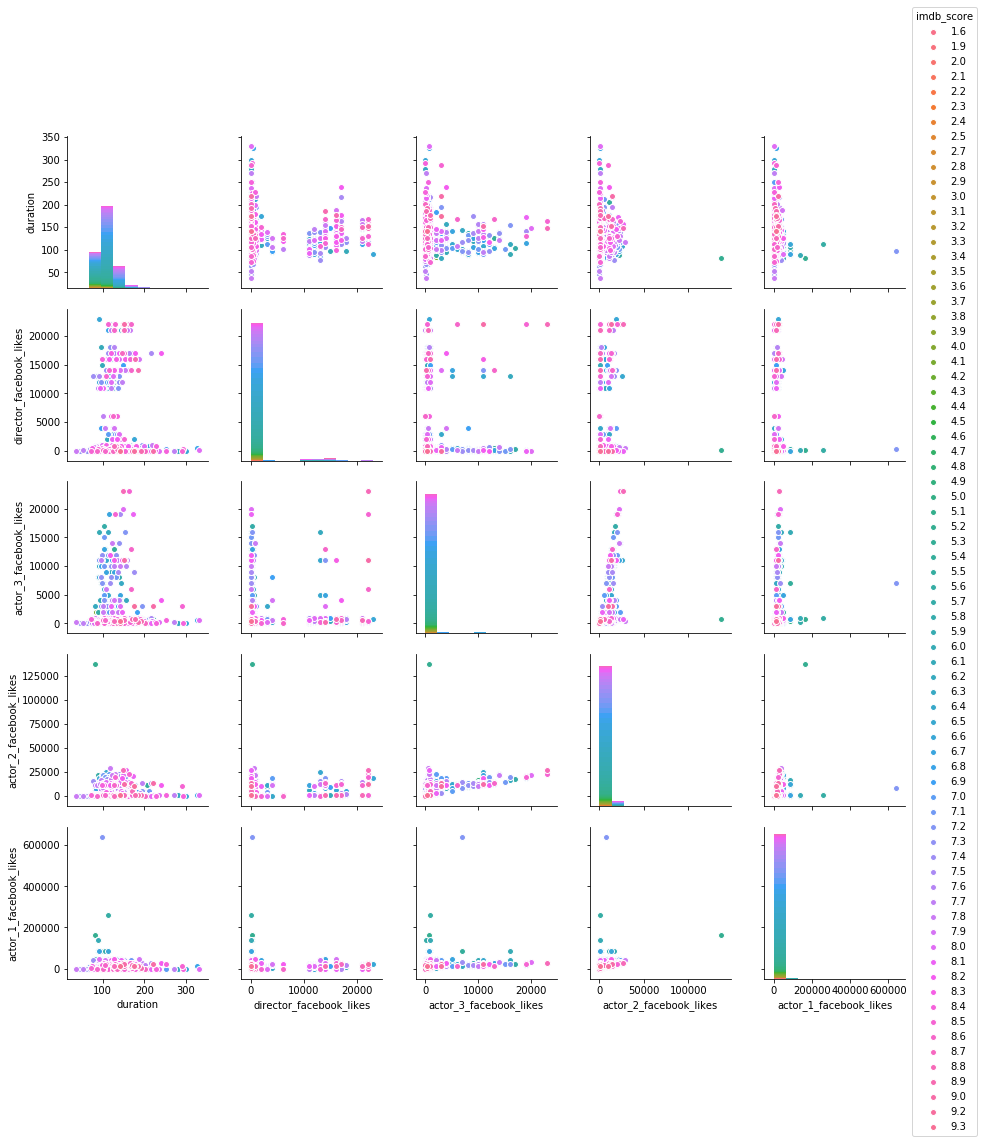

In [3]:
sns.pairplot(imdb, vars=['duration','director_facebook_likes','actor_3_facebook_likes','actor_2_facebook_likes',
                         'actor_1_facebook_likes'], hue='imdb_score')

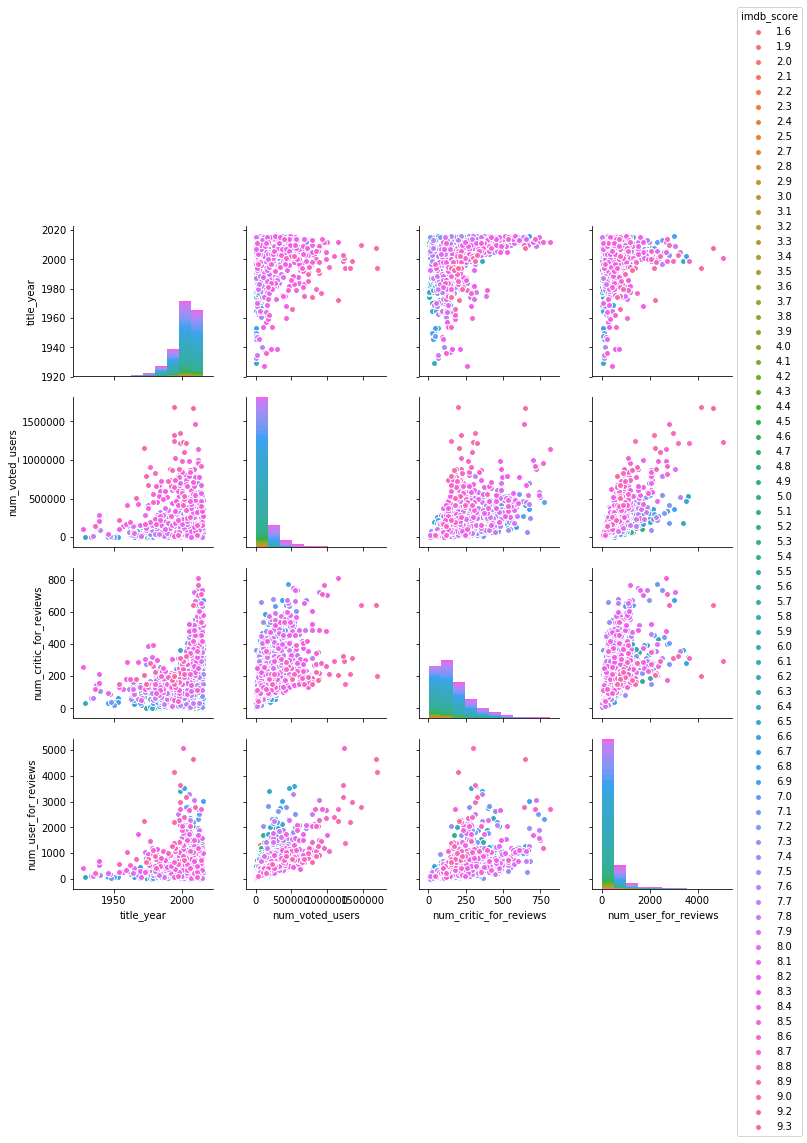

In [4]:
sns.pairplot(imdb, vars=['title_year','num_voted_users','num_critic_for_reviews',
                        'num_user_for_reviews'], hue='imdb_score')

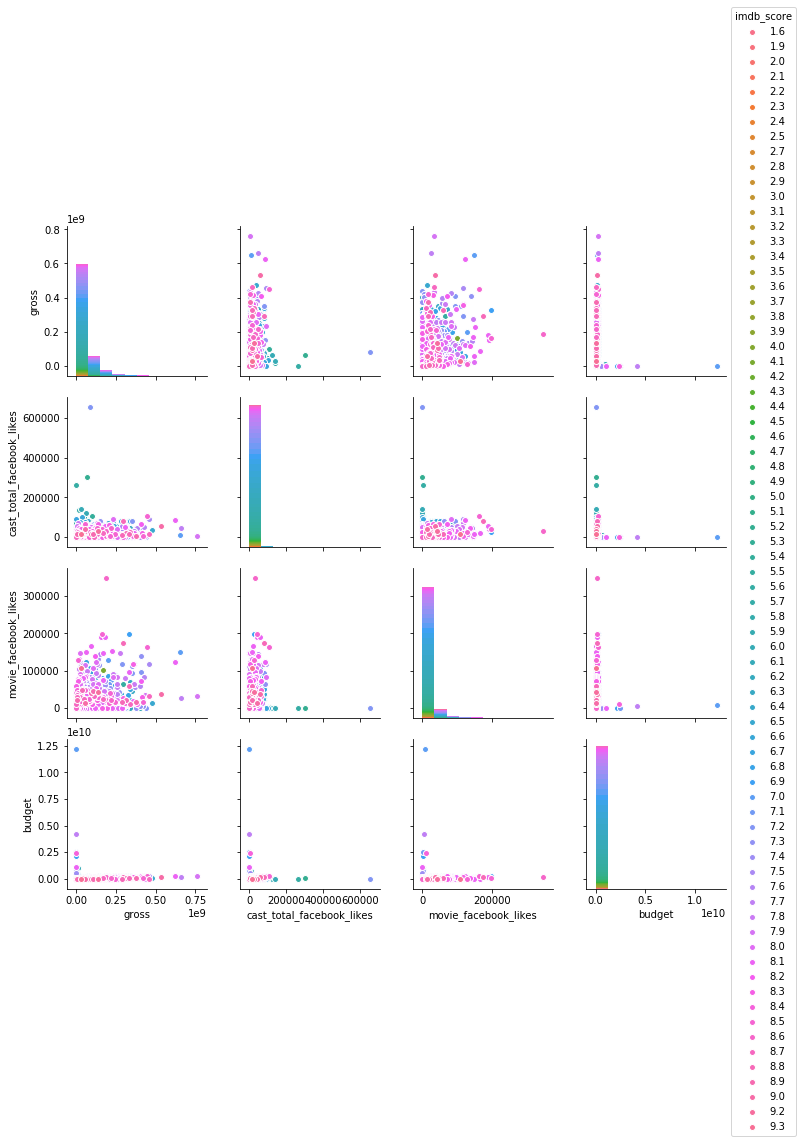

In [5]:
sns.pairplot(imdb, vars=['gross','cast_total_facebook_likes','movie_facebook_likes','budget'], hue='imdb_score')

In [ ]:
imdb.corr()

Olhando as correlações, podemos perceber que tanto o "actor_1_facebook_likes" e "cast_total_facebook_likes" como o "num_voted_users" e "num_user_for_reviews" estão com correlações altíssimas, o que quer dizer que podemos desconsiderar uma das  colunas, pois uma pode explicar a outra. Basta agora escolher qual explica mais.

Além disso, observando os pairplots, vimos que diversos indicadores tem em grande maioria, principalmente os relacionados com likes, valores iguais a zero. Portanto decidimos que seria melhor descartá-los por insuficiência de dados para análise.

In [6]:
imdb_ = imdb.drop(['num_voted_users','num_voted_users','director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_facebook_likes', 'actor_1_facebook_likes', 'cast_total_facebook_likes', 'budget', 'movie_facebook_likes'], axis=1)
imdb_.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'actor_2_name', 'gross', 'genres', 'actor_1_name', 'actor_3_name',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'title_year', 'imdb_score'],
      dtype='object')

In [ ]:
print(imdb_["color"].value_counts())
print(imdb_["language"].value_counts())
print(imdb_["country"].value_counts())
print(imdb_["content_rating"].value_counts())

Novamente por insuficiência de dados para análise, resolvemos que seria melhor descartar "color", "language" e "country".

In [7]:
imdb_ = imdb_.drop(['language','country','color'], axis=1)

In [ ]:
sns.pairplot(imdb_, hue='imdb_score')

## Algorítimo: Montando o classificador
#### Iniciando com Naive Bayes Multiclass

Primeiramente classificamos as notas em 5 grupos: Muito Bom, Bom, Neutro, Ruim e Muito Ruim.

In [8]:
def Evaluation (column):
    if column['imdb_score'] >= 8.0 :
        return 'Muito Bom'
    if column['imdb_score'] < 8.0 and column['imdb_score'] >= 6.5:
        return 'Bom'
    if column['imdb_score'] >= 5.0 and column['imdb_score'] < 6.5:
        return 'Neutro'
    if column['imdb_score'] < 5.0 and column['imdb_score'] >= 3.0:
        return 'Ruim'
    if column['imdb_score'] < 3.0:
        return 'Muito Ruim'

In [9]:
imdb_['Evaluation'] = imdb_.apply(lambda column: Evaluation (column), axis=1)

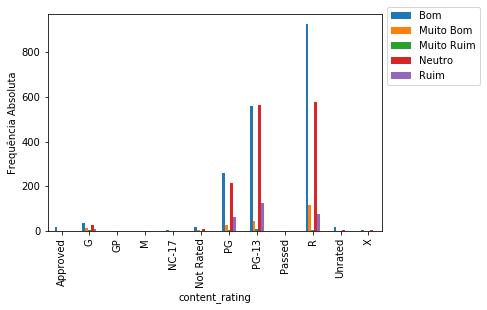

In [30]:
ct1 = pd.crosstab(imdb_.content_rating, imdb_.Evaluation)
ct1.plot(kind='bar')
plt.ylabel('Frequência Absoluta')
plt.legend(loc='center left', bbox_to_anchor=(1,0.85))

 **Variaveis importantes:** Aqui escolhemos as variáveis que, por meio da análise explora
 VOLTAR

In [11]:
imdb2 = imdb_[["director_name", "actor_2_name", 'actor_1_name', 'actor_3_name',"genres", "Evaluation"]]
imdb2['genres'] = imdb2['genres'].apply(lambda x: x.split('|'))
imdb2.head() #trocar para todas as variaveis importantes

C:\Users\marce\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,director_name,actor_2_name,actor_1_name,actor_3_name,genres,Evaluation
movie_title,,,,,,
Avatar,James Cameron,Joel David Moore,CCH Pounder,Wes Studi,"[Action, Adventure, Fantasy, Sci-Fi]",Bom
Pirates of the Caribbean: At World's End,Gore Verbinski,Orlando Bloom,Johnny Depp,Jack Davenport,"[Action, Adventure, Fantasy]",Bom
Spectre,Sam Mendes,Rory Kinnear,Christoph Waltz,Stephanie Sigman,"[Action, Adventure, Thriller]",Bom
The Dark Knight Rises,Christopher Nolan,Christian Bale,Tom Hardy,Joseph Gordon-Levitt,"[Action, Thriller]",Muito Bom
John Carter,Andrew Stanton,Samantha Morton,Daryl Sabara,Polly Walker,"[Action, Adventure, Sci-Fi]",Bom


**Elenco:** Começamos pelo elenco, formado pelo diretor e os três atores principais, de cada filme. Criamos um dataframe separado com cada variável em uma coluna. Construimos um elemento X, baseado no elenco, e um Y, baseado nas avaliações. Depois disso, separamos os dados em uma base de treino e outra de teste, 80% e 20% respectivamente. Com isso pronto, implementamos no modelo Multinomial Naive Bayes, criando os 'vetores' de cada um. Após isso, checamos a acurácia do modelo, que foi de 50% de sucesso, ou seja, classificou corretamente os filmes, a partir do elenco.

In [13]:
imdb_cast = imdb[["director_name", "actor_2_name", 'actor_1_name', 'actor_3_name']]
imdb_cast.head()

,director_name,actor_2_name,actor_1_name,actor_3_name
movie_title,,,,
Avatar,James Cameron,Joel David Moore,CCH Pounder,Wes Studi
Pirates of the Caribbean: At World's End,Gore Verbinski,Orlando Bloom,Johnny Depp,Jack Davenport
Spectre,Sam Mendes,Rory Kinnear,Christoph Waltz,Stephanie Sigman
The Dark Knight Rises,Christopher Nolan,Christian Bale,Tom Hardy,Joseph Gordon-Levitt
John Carter,Andrew Stanton,Samantha Morton,Daryl Sabara,Polly Walker


In [32]:
alldir_actTotal = imdb_cast.values.tolist()
alldir_act = []
for i in alldir_actTotal:
    alldir_act.extend(i)
alldir_act = list(set(alldir_act))

#def dir_actToVec(dir_act):
#    global alldir_act
#    return [1 if str(i) in dir_act else 0 for i in alldir_act]

alldir_actT = []
for listas in alldir_actTotal:
    alldir_actT.append(' '.join(listas))

#--------------
notas = imdb2['Evaluation'].values.tolist()
index_ = round(len(alldir_actT) * 0.8)

X_treino_, X_teste_ = alldir_actT[:index_], alldir_actT[index_:]
Y_treino_, Y_teste_ = notas[:index_], notas[index_:]
len(X_treino_), len(Y_treino_), len(X_teste_), len(Y_teste_)

(3005, 3005, 751, 751)

In [34]:
notas = imdb2['Evaluation'].values.tolist()
index = round((imdb_cast.index.size)*0.8)

X_treino__, X_teste__ = imdb_cast['director_name'][:index], imdb_cast['director_name'][index:]
X_treino_, X_teste_ = imdb_cast['actor_2_name'][:index], imdb_cast['actor_2_name'][index:]
_X_treino, _X_teste = imdb_cast['actor_1_name'][:index], imdb_cast['actor_1_name'][index:]
__X_treino, __X_teste = imdb_cast['actor_3_name'][:index], imdb_cast['actor_3_name'][index:]
X_treino, X_teste = X_treino__ + X_treino_ + _X_treino + __X_treino, X_teste_ +  X_teste__ + _X_teste +  __X_teste

Y_treino, Y_teste = notas[:index], notas[index:]
len(X_treino), len(Y_treino), len(X_teste), len(Y_teste)

(3005, 3005, 751, 751)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Nau=ive Bayes multiclasse é o que está sendo usado aqui
#SVC procurar
#Random Forest
# Cria modelo.
model = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("classifier", MultinomialNB())
])

# Treina modelo.
model.fit(X_treino, Y_treino)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [36]:
Y_pred = model.predict(X_teste)

acc = accuracy_score(Y_teste, Y_pred)
acc

0.5139813581890812

**Genero:** Como para o elenco, fizemos o mesmo para os diferentes genêros, pegando os 7 primeiros de cada um. Criamos outro dataframe separando cada variável em uma coluna. Construimos um elemento X, baseado no gêneros, e um Y, baseado nas avaliações. Depois disso, separamos os dados em uma base de treino e outra de teste, 80% e 20% respectivamente. Com isso pronto, implementamos no modelo Multinomial Naive Bayes, criando os 'vetores' de cada um. Após isso, checamos a acurácia do modelo, que foi de 59% de sucesso, ou seja, classificou corretamente os filmes, a partir dos generos.

In [38]:
imdb_gen = imdb2.drop(['Evaluation',"director_name", "actor_2_name", 'actor_1_name', 'actor_3_name'], axis=1)
#imdb_gen = imdb_gen.join(imdb_gen['genres'].str.split(', ',1, expand=True).rename(columns = {0:'gen1',1:'gen2'}))

In [39]:
gen = imdb2['genres']
Genero_1 = []
Genero_2 = []
Genero_3 = []
Genero_4 = []
Genero_5 = []
Genero_6 = []
Genero_7 = []
for g in gen:
    Genero_1.append(g[0])
    if len(g) < 2:
        Genero_2.append("")
    else:
        Genero_2.append(g[1])
    if len(g) < 3:
        Genero_3.append("")
    else:
        Genero_3.append(g[2])
    if len(g) < 4:
        Genero_4.append("")
    else:
        Genero_4.append(g[3])
    if len(g) < 5:
        Genero_5.append("")
    else:
        Genero_5.append(g[4])
    if len(g) < 6:
        Genero_6.append("")
    else:
        Genero_6.append(g[5])
    if len(g) < 7:
        Genero_7.append("")
    else:
        Genero_7.append(g[6])

In [40]:
imdb_gen["Gen1"] = Genero_1
imdb_gen["Gen2"] = Genero_2
imdb_gen["Gen3"] = Genero_3
imdb_gen["Gen4"] = Genero_4
imdb_gen["Gen5"] = Genero_5
imdb_gen["Gen6"] = Genero_6
imdb_gen["Gen7"] = Genero_7
imdb_gen.head()

,genres,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7
movie_title,,,,,,,,
Avatar,"[Action, Adventure, Fantasy, Sci-Fi]",Action,Adventure,Fantasy,Sci-Fi,,,
Pirates of the Caribbean: At World's End,"[Action, Adventure, Fantasy]",Action,Adventure,Fantasy,,,,
Spectre,"[Action, Adventure, Thriller]",Action,Adventure,Thriller,,,,
The Dark Knight Rises,"[Action, Thriller]",Action,Thriller,,,,,
John Carter,"[Action, Adventure, Sci-Fi]",Action,Adventure,Sci-Fi,,,,


In [41]:
allGenresTotal = imdb2["genres"].values.tolist()
allGenres = []
for i in allGenresTotal:
    allGenres.extend(i)
allGenres = sorted(list(set(allGenres))) #sorted deixa em ordem alfabetica

# def genToVec(gen):
#    global allGenres
#    return [1 if i in gen else 0 for i in allGenres]

# imdb2['genresVec'] = imdb2['genres'].apply(genToVec)
# imdb2['dir_actVec'] = imdb_cast['director_name'].apply(dir_actToVec)
# imdb2.head()

In [42]:
index_gen = round((imdb_gen.index.size)*0.8)

Xgen_treino = imdb_gen['Gen1'][:index_gen] + imdb_gen['Gen2'][:index_gen] + imdb_gen['Gen3'][:index_gen] + imdb_gen['Gen4'][:index_gen] + imdb_gen['Gen5'][:index_gen] + imdb_gen['Gen6'][:index_gen] + imdb_gen['Gen7'][:index_gen]
Xgen_teste = imdb_gen['Gen1'][index_gen:] + imdb_gen['Gen2'][index_gen:] + imdb_gen['Gen3'][index_gen:] + imdb_gen['Gen4'][index_gen:] + imdb_gen['Gen5'][index_gen:] + imdb_gen['Gen6'][index_gen:] + imdb_gen['Gen7'][index_gen:]


Ygen_treino, Ygen_teste = notas[:index], notas[index:]
#len(Xgen_treino), len(Ygen_treino), len(Xgen_teste), len(Ygen_teste)

In [43]:
model.fit(Xgen_treino, Ygen_treino)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [44]:
Ygen_pred = model.predict(Xgen_teste)

acc2 = accuracy_score(Ygen_teste, Ygen_pred)
acc2

0.59254327563249

In [45]:
#Cast + genres

In [46]:
Xcast_genres_treino = Xgen_treino + X_treino
Xcast_genres_teste = Xgen_teste + X_teste

model.fit(Xcast_genres_treino, Ygen_treino)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [47]:
Ycast_genres_pred = model.predict(Xcast_genres_teste)

acc3 = accuracy_score(Y_teste, Ycast_genres_pred)
acc3

0.5406125166444741

In [28]:
#Pondo o resto

In [31]:
imdb_tot = imdb_.drop(['genres','imdb_score'], axis=1).join(imdb_gen)
imdb_tot.head()

,director_name,num_critic_for_reviews,duration,actor_2_name,gross,actor_1_name,actor_3_name,num_user_for_reviews,content_rating,title_year,Evaluation,genres,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7
movie_title,,,,,,,,,,,,,,,,,,,
10 Cloverfield Lane,Dan Trachtenberg,411.0,104.0,John Gallagher Jr.,71897215.0,Bradley Cooper,Sumalee Montano,440.0,PG-13,2016.0,Bom,"[Drama, Horror, Mystery, Sci-Fi, Thriller]",Drama,Horror,Mystery,Sci-Fi,Thriller,,
10 Things I Hate About You,Gil Junger,133.0,97.0,Heath Ledger,38176108.0,Joseph Gordon-Levitt,Andrew Keegan,549.0,PG-13,1999.0,Bom,"[Comedy, Drama, Romance]",Comedy,Drama,Romance,,,,
102 Dalmatians,Kevin Lima,84.0,100.0,Eric Idle,66941559.0,Ioan Gruffudd,Jim Carter,77.0,G,2000.0,Ruim,"[Adventure, Comedy, Family]",Adventure,Comedy,Family,,,,
10th & Wolf,Robert Moresco,26.0,107.0,Brad Renfro,53481.0,Brian Dennehy,Dash Mihok,34.0,R,2006.0,Neutro,"[Crime, Drama, Thriller]",Crime,Drama,Thriller,,,,
12 Rounds,Renny Harlin,113.0,108.0,Ashley Scott,12232937.0,Taylor Cole,Nick Gomez,113.0,PG-13,2009.0,Neutro,"[Action, Crime, Thriller]",Action,Crime,Thriller,,,,
